# Clustering of genomic data

The aim of the analysis is to find some relevant data patterns through the application of clustering techniques on the dataset stored in data.txt. 

As shown in data.ipynb and data_processing.ipynb, the dataset consists of both genomic and clinical data;
custering is applied on genomic features, while some clinical features are considered as true labels and the outcome of the cluster analysis is compared with the clinical classification.

At the current state of the art, no evident correspondance between genomic data and clinical outcomes has been found; for this reason, supervised classification is not considered, since the training of data may be biased by false correspondance between features and classifications.

The failure of the following methods may be therefore due to both bad algorithm performances and real lack of correlation between genomic and clinical features.

#### Contents:
1. [Sample selection](#2)<br>
2. [Label exploration](#3)<br>
3. [Cluster analysis](#4)<br>
    3.1 [Clustering metrics](#3.1)<br>
    3.2 [Clustering methods](#3.2)<br>
    3.3 [Clustering on non-reduced dimensional dataset](#3.3)<br>
    3.4 [Clustering after dimensionality reduction](#3.4)<br>
    3.5 [Clustering of only gene expression features](#3.5)<br>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pylab as plt
import warnings

## 1. Sample selection<a class="anchor" id="1"></a>

After importing the dataset as pandas dataframe, select only patients with all genomic features (presence of gene mutations and copy number aberrations, gene expressions and methylation values).

In [2]:
warnings.filterwarnings('ignore')

data_complete = pd.read_csv('data/data_processed.txt', sep='\t')
print('Total number of patients: ', len(data_complete))

data = data_complete.query("mut==True and cna==True and rna==True and meth==True").copy()
print('Number of patients with all genomic features: ', len(data))

Total number of patients:  2454
Number of patients with all genomic features:  1253


In [3]:
data

,mut_AKT1,mut_ARID1A,mut_ARID1B,mut_BAP1,mut_BRCA1,mut_BRCA2,mut_BRIP1,mut_CASP8,mut_CDH1,mut_CDKN1B,...,HER2_STATUS,PR_STATUS,COHORT,ER_IHC,HER2_SNP6,INTCLUST,CLAUDIN_SUBTYPE,THREEGENE,HISTOLOGICAL_SUBTYPE,PATIENT_ID
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Negative,Positive,1.0,Positve,NEUTRAL,9,LumB,NaN,Mixed,MB-0006
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Negative,Negative,1.0,Positve,GAIN,9,LumB,ER+/HER2- High Prolif,Ductal/NST,MB-0028
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,Negative,Negative,1.0,Negative,LOSS,3,Her2,ER+/HER2- High Prolif,Lobular,MB-0035
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Positive,Positive,1.0,Positve,GAIN,5,LumA,NaN,Ductal/NST,MB-0046
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Negative,Positive,1.0,Positve,GAIN,10,LumB,NaN,Ductal/NST,MB-0054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Negative,Negative,4.0,Positve,NEUTRAL,8,LumB,ER+/HER2- High Prolif,Ductal/NST,MB-7288
1975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Negative,Positive,4.0,Positve,GAIN,4ER+,Normal,ER+/HER2- Low Prolif,Ductal/NST,MB-7289
1976,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Positive,Negative,4.0,Positve,GAIN,1,claudin-low,HER2+,Ductal/NST,MB-7291
1978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Negative,Positive,4.0,Positve,NEUTRAL,3,LumA,ER+/HER2- Low Prolif,Ductal/NST,MB-7293


Name columns depending on the feature type.

In [4]:
cols_mut = data.columns[:28].tolist()
cols_cna = data.columns[28:154].tolist()
cols_rna = data.columns[154:216].tolist()
cols_meth = data.columns[216:-17].tolist()

## 2. Label exploration<a class="anchor" id="2"></a>

Count number of identical values of clinical features and verify presence of missing values.

In [5]:
#['TMB_NONSYNONYMOUS','COHORT','GRADE',ER_STATUS','ER_IHC','HER2_STATUS','HER2_SNP6','PR_STATUS','INTCLUST','CLAUDIN_SUBTYPE','THREEGENE','HISTOLOGICAL_SUBTYPE']
cols_clin = data.columns[-13:]
for i in cols_clin[1:-1]:
    print(data[i].value_counts())
    print('Number of NaN: ',data[i].isna().sum(),'\n')

GRADE
3.0    611
2.0    488
1.0    107
Name: count, dtype: int64
Number of NaN:  47 

ER_STATUS
Positive    955
Negative    298
Name: count, dtype: int64
Number of NaN:  0 

HER2_STATUS
Negative    1094
Positive     159
Name: count, dtype: int64
Number of NaN:  0 

PR_STATUS
Positive    653
Negative    600
Name: count, dtype: int64
Number of NaN:  0 

COHORT
3.0    451
1.0    316
2.0    205
4.0    147
5.0    134
Name: count, dtype: int64
Number of NaN:  0 

ER_IHC
Positve     942
Negative    290
Name: count, dtype: int64
Number of NaN:  21 

HER2_SNP6
NEUTRAL    912
GAIN       270
LOSS        70
UNDEF        1
Name: count, dtype: int64
Number of NaN:  0 

INTCLUST
8       206
3       192
10      153
4ER+    137
7       125
5       122
9        94
1        81
6        55
2        45
4ER-     43
Name: count, dtype: int64
Number of NaN:  0 

CLAUDIN_SUBTYPE
LumA           458
LumB           279
Her2           163
Basal          140
claudin-low    118
Normal          90
NC               5


In [36]:
clinical_class_name = ['ER_STATUS','HER2_STATUS','PR_STATUS','ER_IHC','HER2_SNP6','GRADE','COHORT','THREEGENE','CLAUDIN_SUBTYPE','INTCLUST']
clinical_class_number = [2,2,2,2,3,3,5,4,6,11]

In [7]:
X = data[cols_mut+cols_cna+cols_rna+cols_meth].copy()
Y = data[data.columns[-12:-1]].copy()

In [ ]:
#grade: aggressività cellule 
#cohort: caratteristiche specifiche non si sa di che natura
    
#er_status, er_ihc, her2_status, her2_snp6, pr_status

#INTCLUST, CLAUDIN_SUBTYPE da gene expression
#THREEGENE 

## 3. Cluster analysis <a class="anchor" id="3"></a>

### 3.1 Clustering metrics <a class="anchor" id="3.1"></a>

In [8]:
from sklearn.metrics import fowlkes_mallows_score as fms
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import adjusted_rand_score as ars

### 3.2 Clustering methods <a class="anchor" id="3.2"></a>

In [26]:

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
#from sklearn.cluster import HDBSCAN
#from sklearn.cluster import SpectralClustering

### 3.3 Clustering on non-reduced dimensional dataset <a class="anchor" id="3.3"></a>

In this section two clustering methods that deal with mixed data type are directly applied on the dataset, without any preprocessing. In particular, genetic mutation (cols_mut) and copy number alteration (cols_cna) data are binary, while rna expression (cols_rna) and methylation (cols_meth) data are real number between zero and one.

Firstly, Agglomerative Clustering is run with Gower distance, a measure that uses the concept of Manhattan distance for continuous variables and Dice distance for measuring similarity between binary variables.

Secondly, k-Prototypes algorithm is used, since it integrates k-Means for numeric data and k-Modes for categorical data.

For each method, Adjusted Mutual Information, Adjusted Rand Index and Fowlkes Mallows Score are computed for any possible classification of the dataset given by clinical features.

#### Agglomerative Clustering with Gower distance

In [33]:
import gower
from sklearn.cluster import AgglomerativeClustering

In [40]:
dist_matrix = gower.gower_matrix(X)

for i in np.arange(len(clinical_class_name)):
    if (i==0) or (clinical_class_number[i] != clinical_class_number[i-1]):
        ac = AgglomerativeClustering(n_clusters=clinical_class_number[i], metric = "precomputed", linkage='complete').fit(dist_matrix)
    
    # delete rows with missing labels
    name = clinical_class_name[i]
    c = Y[name]
    df = pd.DataFrame([c,ac.labels_])
    df = df.T
    df.columns = [0,1]
    df = df.dropna()
    
    print(name)
    print('Number of clusters: ', len(np.unique(ac.labels_)))
    print('Adjusted Mutual Information: ', ami(df[0],df[1]))
    print('Adjusted Rand Index: ', ars(df[0],df[1]))
    print('Fowlkes Mallows Score: ', fms(df[0],df[1]),'\n')

ER_STATUS
Number of clusters:  2
Adjusted Mutual Information:  -0.00042170594984953396
Adjusted Rand Index:  0.015469884217736353
Fowlkes Mallows Score:  0.7394327977206036 

HER2_STATUS
Number of clusters:  2
Adjusted Mutual Information:  0.0005292165840629978
Adjusted Rand Index:  0.030819750514930556
Fowlkes Mallows Score:  0.8149840018467118 

PR_STATUS
Number of clusters:  2
Adjusted Mutual Information:  -0.0009620112766338206
Adjusted Rand Index:  0.0004632030483713186
Fowlkes Mallows Score:  0.6466396758340441 

ER_IHC
Number of clusters:  2
Adjusted Mutual Information:  -0.0014267346778472092
Adjusted Rand Index:  -0.0009920590869510247
Fowlkes Mallows Score:  0.7386002430739993 

HER2_SNP6
Number of clusters:  3
Adjusted Mutual Information:  0.000737087314294286
Adjusted Rand Index:  -0.00575679671474105
Fowlkes Mallows Score:  0.6648825700722323 

GRADE
Number of clusters:  3
Adjusted Mutual Information:  -0.003108188589070628
Adjusted Rand Index:  0.005375874679791025
Fowlke

#### K-Prototypes

In [43]:
from kmodes.kprototypes import KPrototypes

In [58]:
for i in np.arange(len(clinical_class_name)):
    if (i==0) or (clinical_class_number[i] != clinical_class_number[i-1]):
        kp = KPrototypes(n_clusters=clinical_class_number[i]).fit_predict(X, categorical=np.arange(len(cols_mut+cols_cna)).tolist())
    
    # delete rows with missing labels
    name = clinical_class_name[i]
    c = Y[name]
    df = pd.DataFrame([c,kp])
    df = df.T
    df.columns = [0,1]
    df = df.dropna()
    
    print(name)
    print('Number of clusters: ', len(np.unique(ac.labels_)))
    print('Adjusted Mutual Information: ', ami(df[0],df[1]))
    print('Adjusted Rand Index: ', ars(df[0],df[1]))
    print('Fowlkes Mallows Score: ', fms(df[0],df[1]),'\n')

ER_STATUS
Number of clusters:  11
Adjusted Mutual Information:  0.0019767351364062937
Adjusted Rand Index:  0.025388201304152216
Fowlkes Mallows Score:  0.6395742196291934 

HER2_STATUS
Number of clusters:  11
Adjusted Mutual Information:  0.0031385185259717547
Adjusted Rand Index:  0.03253250126418808
Fowlkes Mallows Score:  0.7037146100870854 

PR_STATUS
Number of clusters:  11
Adjusted Mutual Information:  0.004034138301294913
Adjusted Rand Index:  0.007775418767235042
Fowlkes Mallows Score:  0.5576086559336478 

ER_IHC
Number of clusters:  11
Adjusted Mutual Information:  -0.0004881177882688443
Adjusted Rand Index:  0.010182023469377221
Fowlkes Mallows Score:  0.6354005725725589 

HER2_SNP6
Number of clusters:  11
Adjusted Mutual Information:  -0.0004438391260538314
Adjusted Rand Index:  -0.009384806400960382
Fowlkes Mallows Score:  0.49976398986358417 

GRADE
Number of clusters:  11
Adjusted Mutual Information:  -0.0013238789191530995
Adjusted Rand Index:  -0.002034534556257172
Fo

Both methods provide very bad results for any possible considered classification. Even in presence of real correspondance between genomic data and clinical classification, it would be very difficult to find good results with such high number of features, if compared with the number of patients.
In order to overcome the problem of curse of dimensionality, dimensionality reduction is applied before clustering in the next section.

### 3.4 Clustering after dimensionality reduction  <a class="anchor" id="3.4"></a>

Since the dataset consists of 270 genomic features (cols_mut, cols_cna, cols_rna, cols_meth) and the number of patients (rows) is 1253, it is convenient to apply dimensionality reduction before clustering analysis. 

Two methods are used to perform dimensionality reduction: Factor Analysis of Mixed Data (FAMD) and Autoencoder (AE).

Cluster analysis is then applied on the lower-dimensional latent space using k-Means clustering and Hierarchical Clustering.

In [61]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

tre metodi di dimensionality reduction in 2 e 3 dimensioni (dati separati o tutti insieme), poi calcola numero di dimensioni migliori e applica clustering nel nuovo spazio.
poi fai dimensionality reduction con autoencoder (dataset completo) e applica stessi algoritmi dello spazio latente

#### Factor Analysis of Mixed Data

In [62]:
from prince import FAMD

FAMD applies two different dimensionality reduction methods for categorical and continuous variables (respectively MCA and PCA). In order to make it automatically recognize the two different feature typologies, the type of the binary features is changed from float to str.

The plot shows the cumulative variance percentage in function of the number of dimensions. It is used in order to choose the lower number of components that doesn't loose too much information. In this case the threshold is set to 90% of variance. 

Number of components with 90% of cumulative variance percentage:  89


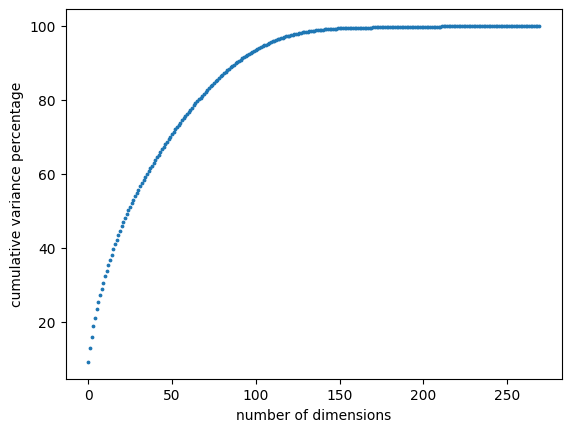

In [63]:
x = X.copy()
# change binary feature type
x[cols_mut+cols_cna] = x[cols_mut+cols_cna].astype(str)

famd = FAMD(n_components=len(x.columns)).fit(x)

plt.scatter(np.arange(len(x.columns)),famd.cumulative_percentage_of_variance_,s=3)
plt.xlabel('number of dimensions')
plt.ylabel('cumulative variance percentage')

n_comp = np.where(famd.cumulative_percentage_of_variance_>90)[0][0]
print('Number of components with 90% of cumulative variance percentage: ', n_comp)

Apply dimensionality reduction method with 89 components.

In [64]:
famd = FAMD(n_components=n_comp).fit_transform(x)
famd

component,0,1,2,3,4,5,6,7,8,9,...,79,80,81,82,83,84,85,86,87,88
3,-8.668662,43.419140,38.131332,39.895812,-19.630997,-40.476784,-19.717120,-34.584141,22.566647,58.289376,...,-9.214103,7.974953,-7.167947,5.655478,7.686512,1.386188,8.709041,1.058065,-3.042781,13.832417
10,41.824004,49.630579,-24.281010,-45.171207,16.882798,11.799826,4.391324,24.143017,27.471359,-5.331847,...,11.801624,-4.403765,10.228549,-8.217542,-24.842737,-6.899494,3.121413,10.922600,5.886901,1.843799
11,11.902807,-26.776110,15.763438,-16.997493,-31.584422,28.764560,30.052672,2.155859,-7.444833,25.861274,...,-7.443185,-4.598526,-10.552656,6.754514,-4.015201,6.125942,5.271119,-6.736877,-3.225242,-0.344676
15,6.958952,-1.484429,-18.635168,-18.401841,2.819554,17.039618,12.253624,2.561770,-2.471273,6.410387,...,-7.106984,4.336794,2.927494,-1.873261,0.814480,0.239901,-0.379181,-8.999357,7.305933,-15.366145
19,33.270260,52.715350,-24.636384,45.858728,-13.988004,-6.313426,20.020594,21.443854,8.928814,-25.801778,...,-6.994168,-14.027648,4.204347,6.312214,-6.152283,-10.133255,8.205742,-19.037536,-10.769096,12.989000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1974,-24.780874,-5.068675,-0.590721,-9.617058,-5.500182,-2.607198,9.188635,-8.496904,-6.156880,-1.463843,...,5.494286,-3.481056,8.933542,-3.828536,-0.457762,-9.841990,-6.592294,1.963209,-0.524334,2.890858
1975,0.218312,-30.231753,9.702778,-23.493031,-39.624312,8.355335,6.879599,1.036120,-1.337167,1.527238,...,7.918844,-10.604747,0.131206,7.139322,-11.344305,-7.955521,-5.487386,0.277668,5.217412,-2.638890
1976,-29.469502,5.671441,-23.353418,12.167031,-11.216314,-1.985570,-14.440253,20.826159,7.472923,2.281285,...,7.663629,3.927341,-0.357392,-1.392647,-1.292986,-1.607468,-8.003603,-2.954419,5.216284,-7.383567
1978,-2.226814,19.449007,-15.687968,-1.435842,1.709954,-4.688224,-9.944311,-21.207712,-31.168792,11.787943,...,-3.270110,-0.305609,0.920177,-3.125336,-4.529716,-8.252269,-1.667498,-3.115822,2.255234,-0.086729


#### K-Means clustering after FAMD

In [65]:
for i in np.arange(len(clinical_class_name)):
    if (i==0) or (clinical_class_number[i] != clinical_class_number[i-1]):
        clust = KMeans(n_clusters=clinical_class_number[i],random_state=0).fit_predict(np.array(famd))

    # delete rows with missing labels
    name = clinical_class_name[i]
    c = Y[name]
    df = pd.DataFrame([c,clust])
    df = df.T
    df.columns = [0,1]
    df = df.dropna()
    
    print(name)
    print(ami(df[0],df[1]))
    print(ars(df[0],df[1]))
    print(fms(df[0],df[1]),'\n')

ER_STATUS
0.00023897015523446412
0.012521046372413525
0.6106770927987379 

HER2_STATUS
0.0010870589765998202
0.017934682948554912
0.6727918488185971 

PR_STATUS
0.0030311727514205303
0.006268172407855902
0.535533358440766 

ER_IHC
-0.0009257972585181371
0.002773384071673532
0.6089350320403208 

HER2_SNP6
-0.002543560550636012
-0.005458114573594888
0.47905487826065757 

GRADE
-0.0005017998301562616
4.090519007743504e-05
0.41712727782640574 

COHORT
0.002682447947705787
0.005198028211646018
0.3663772927527061 

THREEGENE
0.00032882182419951655
0.0036545778446684177
0.3327677003170452 

CLAUDIN_SUBTYPE
0.0014085382639520468
0.00485627037394807
0.2770018983832758 

INTCLUST
0.002317879535370364
-0.0038555873844941598
0.15387728194167458 



#### Agglomerative Clustering after FAMD

In [93]:
for i in np.arange(len(clinical_class_name)):
    if (i==0) or (clinical_class_number[i] != clinical_class_number[i-1]):
        clust = AgglomerativeClustering(n_clusters=clinical_class_number[i]).fit_predict(np.array(famd))

    name = clinical_class_name[i]
    c = Y[name]
    df = pd.DataFrame([c,clust])
    df = df.T
    df.columns = [0,1]
    df = df.dropna()
    
    print(name)
    print(ami(df[0],df[1]))
    print(ars(df[0],df[1]))
    print(fms(df[0],df[1]),'\n')

ER_STATUS
0.005503998745840852
0.04403551745794944
0.6728781997992365 

HER2_STATUS
0.0013213924050765884
0.02909865565549854
0.7320286734887517 

PR_STATUS
0.0024235820027648683
0.0054268007757059915
0.5807404111286805 

ER_IHC
0.0004378950868366006
0.020353456195750748
0.6693198820860472 

HER2_SNP6
0.0004651404694602971
0.016414943682968895
0.6188271276301577 

GRADE
0.000348670297694419
-0.010211684675134244
0.5229574397648837 

COHORT
0.0020375044031300795
-0.004041606159778791
0.3361817695241319 

THREEGENE
-0.0010310720118357844
0.0056705566126745936
0.3295811422726861 

CLAUDIN_SUBTYPE
0.0011890518515696245
0.017939398004291035
0.2929691452052398 

INTCLUST
-0.0008836339613634686
0.0016622838459210032
0.1646987099522805 



#### Autoencoder

In this section a deep neural network with a low dimensional latent space is used to reduce the dimensionality of the input space. The class of the autoencoder is defined in autoencoder.py. 
The class requires in input a list with a number of elements equal to the number of layers of the encoder; each element is an integer number indicating the number of nodes contained in the corresponding layer.
The decoder has the same inverted structure. The central layer represents the latent space in which the data are projected in a lower dimension.

The sequence of layers used here (and found in literature, see https://arxiv.org/abs/1511.06335) is [d, 500, 500, 2000, 10], where d is the number of input dimensions.

In [85]:
from autoencoder import AE

In [94]:
dims = [270, 500, 500, 2000, 10]
ae = AE(dims)
ae.autoencoder.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 270)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               135500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 decoder_3 (Dense)           (None, 2000)              22000     
                                                                 
 decoder_2 (Dense)           (None, 500)               1000500  

In [89]:
history = ae.train(X,epochs=1000)

Epoch 1/1000
63/63 [==============================] - 2s 20ms/step - loss: 0.1263
Epoch 2/1000
63/63 [==============================] - 1s 19ms/step - loss: 0.1250
Epoch 3/1000
63/63 [==============================] - 1s 19ms/step - loss: 0.1238
Epoch 4/1000
63/63 [==============================] - 2s 27ms/step - loss: 0.1225
Epoch 5/1000
63/63 [==============================] - 2s 29ms/step - loss: 0.1213
Epoch 6/1000
63/63 [==============================] - 2s 27ms/step - loss: 0.1200
Epoch 7/1000
63/63 [==============================] - 2s 27ms/step - loss: 0.1188
Epoch 8/1000
63/63 [==============================] - 2s 24ms/step - loss: 0.1175
Epoch 9/1000
63/63 [==============================] - 2s 24ms/step - loss: 0.1162
Epoch 10/1000
63/63 [==============================] - 1s 21ms/step - loss: 0.1149
Epoch 11/1000
63/63 [==============================] - 1s 21ms/step - loss: 0.1136
Epoch 12/1000
63/63 [==============================] - 1s 22ms/step - loss: 0.1123
Epoch 13/1000

63/63 [==============================] - 2s 24ms/step - loss: 0.0584
Epoch 100/1000
63/63 [==============================] - 2s 28ms/step - loss: 0.0584
Epoch 101/1000
63/63 [==============================] - 2s 29ms/step - loss: 0.0584
Epoch 102/1000
63/63 [==============================] - 1s 23ms/step - loss: 0.0584
Epoch 103/1000
63/63 [==============================] - 2s 28ms/step - loss: 0.0584
Epoch 104/1000
63/63 [==============================] - 2s 24ms/step - loss: 0.0583
Epoch 105/1000
63/63 [==============================] - 2s 27ms/step - loss: 0.0583
Epoch 106/1000
63/63 [==============================] - 1s 18ms/step - loss: 0.0583
Epoch 107/1000
63/63 [==============================] - 1s 21ms/step - loss: 0.0583
Epoch 108/1000
63/63 [==============================] - 1s 18ms/step - loss: 0.0583
Epoch 109/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0583
Epoch 110/1000
63/63 [==============================] - 1s 20ms/step - loss: 0.0583
Epoch 1

63/63 [==============================] - 1s 17ms/step - loss: 0.0573
Epoch 197/1000
63/63 [==============================] - 1s 18ms/step - loss: 0.0573
Epoch 198/1000
63/63 [==============================] - 1s 21ms/step - loss: 0.0572
Epoch 199/1000
63/63 [==============================] - 1s 21ms/step - loss: 0.0572
Epoch 200/1000
63/63 [==============================] - 1s 21ms/step - loss: 0.0572
Epoch 201/1000
63/63 [==============================] - 1s 20ms/step - loss: 0.0572
Epoch 202/1000
63/63 [==============================] - 1s 18ms/step - loss: 0.0572
Epoch 203/1000
63/63 [==============================] - 1s 23ms/step - loss: 0.0572
Epoch 204/1000
63/63 [==============================] - 1s 18ms/step - loss: 0.0571
Epoch 205/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0571
Epoch 206/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0571
Epoch 207/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0571
Epoch 2

63/63 [==============================] - 1s 20ms/step - loss: 0.0553
Epoch 294/1000
63/63 [==============================] - 1s 19ms/step - loss: 0.0553
Epoch 295/1000
63/63 [==============================] - 1s 20ms/step - loss: 0.0553
Epoch 296/1000
63/63 [==============================] - 1s 21ms/step - loss: 0.0553
Epoch 297/1000
63/63 [==============================] - 1s 20ms/step - loss: 0.0552
Epoch 298/1000
63/63 [==============================] - 1s 20ms/step - loss: 0.0552
Epoch 299/1000
63/63 [==============================] - 1s 19ms/step - loss: 0.0552
Epoch 300/1000
63/63 [==============================] - 1s 20ms/step - loss: 0.0552
Epoch 301/1000
63/63 [==============================] - 1s 19ms/step - loss: 0.0551
Epoch 302/1000
63/63 [==============================] - 1s 19ms/step - loss: 0.0551
Epoch 303/1000
63/63 [==============================] - 1s 22ms/step - loss: 0.0551
Epoch 304/1000
63/63 [==============================] - 1s 20ms/step - loss: 0.0551
Epoch 3

63/63 [==============================] - 1s 19ms/step - loss: 0.0530
Epoch 391/1000
63/63 [==============================] - 1s 18ms/step - loss: 0.0530
Epoch 392/1000
63/63 [==============================] - 1s 19ms/step - loss: 0.0530
Epoch 393/1000
63/63 [==============================] - 1s 23ms/step - loss: 0.0529
Epoch 394/1000
63/63 [==============================] - 1s 21ms/step - loss: 0.0529
Epoch 395/1000
63/63 [==============================] - 1s 20ms/step - loss: 0.0529
Epoch 396/1000
63/63 [==============================] - 1s 23ms/step - loss: 0.0529
Epoch 397/1000
63/63 [==============================] - 2s 24ms/step - loss: 0.0529
Epoch 398/1000
63/63 [==============================] - 1s 18ms/step - loss: 0.0529
Epoch 399/1000
63/63 [==============================] - 1s 19ms/step - loss: 0.0528
Epoch 400/1000
63/63 [==============================] - 1s 20ms/step - loss: 0.0528
Epoch 401/1000
63/63 [==============================] - 1s 21ms/step - loss: 0.0528
Epoch 4

63/63 [==============================] - 1s 16ms/step - loss: 0.0517
Epoch 488/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0517
Epoch 489/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0517
Epoch 490/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0517
Epoch 491/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0517
Epoch 492/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0517
Epoch 493/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0517
Epoch 494/1000
63/63 [==============================] - 1s 17ms/step - loss: 0.0516
Epoch 495/1000
63/63 [==============================] - 1s 17ms/step - loss: 0.0516
Epoch 496/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0516
Epoch 497/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0516
Epoch 498/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0516
Epoch 4

63/63 [==============================] - 1s 15ms/step - loss: 0.0510
Epoch 585/1000
63/63 [==============================] - 1s 15ms/step - loss: 0.0509
Epoch 586/1000
63/63 [==============================] - 1s 15ms/step - loss: 0.0509
Epoch 587/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0509
Epoch 588/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0509
Epoch 589/1000
63/63 [==============================] - 1s 15ms/step - loss: 0.0509
Epoch 590/1000
63/63 [==============================] - 1s 14ms/step - loss: 0.0509
Epoch 591/1000
63/63 [==============================] - 1s 14ms/step - loss: 0.0509
Epoch 592/1000
63/63 [==============================] - 1s 14ms/step - loss: 0.0509
Epoch 593/1000
63/63 [==============================] - 1s 14ms/step - loss: 0.0509
Epoch 594/1000
63/63 [==============================] - 1s 15ms/step - loss: 0.0509
Epoch 595/1000
63/63 [==============================] - 1s 15ms/step - loss: 0.0509
Epoch 5

63/63 [==============================] - 1s 18ms/step - loss: 0.0503
Epoch 682/1000
63/63 [==============================] - 1s 19ms/step - loss: 0.0503
Epoch 683/1000
63/63 [==============================] - 1s 18ms/step - loss: 0.0502
Epoch 684/1000
63/63 [==============================] - 1s 21ms/step - loss: 0.0502
Epoch 685/1000
63/63 [==============================] - 1s 21ms/step - loss: 0.0502
Epoch 686/1000
63/63 [==============================] - 1s 17ms/step - loss: 0.0502
Epoch 687/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0502
Epoch 688/1000
63/63 [==============================] - 1s 15ms/step - loss: 0.0502
Epoch 689/1000
63/63 [==============================] - 1s 17ms/step - loss: 0.0502
Epoch 690/1000
63/63 [==============================] - 1s 15ms/step - loss: 0.0502
Epoch 691/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0502
Epoch 692/1000
63/63 [==============================] - 1s 15ms/step - loss: 0.0502
Epoch 6

63/63 [==============================] - 1s 18ms/step - loss: 0.0495
Epoch 779/1000
63/63 [==============================] - 1s 19ms/step - loss: 0.0495
Epoch 780/1000
63/63 [==============================] - 1s 18ms/step - loss: 0.0495
Epoch 781/1000
63/63 [==============================] - 1s 20ms/step - loss: 0.0495
Epoch 782/1000
63/63 [==============================] - 1s 19ms/step - loss: 0.0495
Epoch 783/1000
63/63 [==============================] - 1s 17ms/step - loss: 0.0495
Epoch 784/1000
63/63 [==============================] - 1s 17ms/step - loss: 0.0495
Epoch 785/1000
63/63 [==============================] - 1s 17ms/step - loss: 0.0494
Epoch 786/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0494
Epoch 787/1000
63/63 [==============================] - 1s 17ms/step - loss: 0.0494
Epoch 788/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0494
Epoch 789/1000
63/63 [==============================] - 1s 17ms/step - loss: 0.0494
Epoch 7

63/63 [==============================] - 1s 15ms/step - loss: 0.0487
Epoch 876/1000
63/63 [==============================] - 1s 15ms/step - loss: 0.0486
Epoch 877/1000
63/63 [==============================] - 1s 15ms/step - loss: 0.0486
Epoch 878/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0486
Epoch 879/1000
63/63 [==============================] - 1s 15ms/step - loss: 0.0486
Epoch 880/1000
63/63 [==============================] - 1s 15ms/step - loss: 0.0486
Epoch 881/1000
63/63 [==============================] - 1s 15ms/step - loss: 0.0486
Epoch 882/1000
63/63 [==============================] - 1s 15ms/step - loss: 0.0486
Epoch 883/1000
63/63 [==============================] - 1s 15ms/step - loss: 0.0486
Epoch 884/1000
63/63 [==============================] - 1s 15ms/step - loss: 0.0486
Epoch 885/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0486
Epoch 886/1000
63/63 [==============================] - 1s 15ms/step - loss: 0.0486
Epoch 8

63/63 [==============================] - 1s 19ms/step - loss: 0.0477
Epoch 973/1000
63/63 [==============================] - 1s 17ms/step - loss: 0.0477
Epoch 974/1000
63/63 [==============================] - 1s 19ms/step - loss: 0.0477
Epoch 975/1000
63/63 [==============================] - 1s 17ms/step - loss: 0.0477
Epoch 976/1000
63/63 [==============================] - 1s 17ms/step - loss: 0.0477
Epoch 977/1000
63/63 [==============================] - 1s 17ms/step - loss: 0.0476
Epoch 978/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0476
Epoch 979/1000
63/63 [==============================] - 1s 17ms/step - loss: 0.0476
Epoch 980/1000
63/63 [==============================] - 1s 17ms/step - loss: 0.0476
Epoch 981/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0476
Epoch 982/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0476
Epoch 983/1000
63/63 [==============================] - 1s 16ms/step - loss: 0.0476
Epoch 9

Text(0, 0.5, 'Loss')

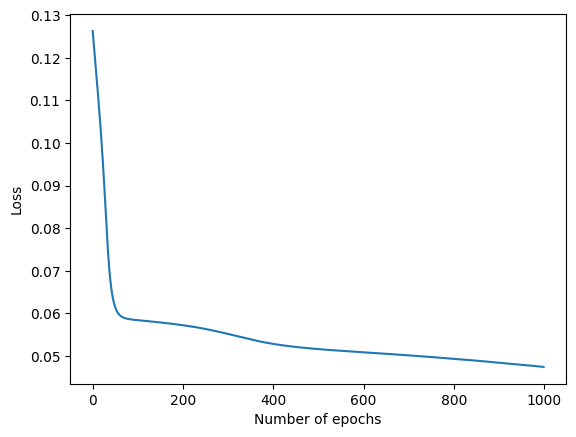

In [92]:
hist = history.history['loss']
plt.plot(np.arange(len(hist)),hist)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')

In [98]:
feat = ae.extract_features(X)
feat.shape

40/40 [==============================] - 0s 4ms/step


(1253, 10)

In [99]:
weights = ae.extract_weights()
weights

[<tf.Variable 'encoder_0/kernel:0' shape=(270, 500) dtype=float32, numpy=
 array([[-0.0412654 , -0.00081942,  0.05782517, ..., -0.05768577,
         -0.0299992 ,  0.00902852],
        [-0.00695752,  0.03877672, -0.07250419, ..., -0.01958048,
         -0.03847662, -0.0248206 ],
        [ 0.06281935, -0.01760093,  0.02801344, ...,  0.02906072,
         -0.0547568 ,  0.01911831],
        ...,
        [ 0.00266699,  0.08795609, -0.02388738, ..., -0.03773964,
          0.07604071, -0.06934275],
        [ 0.02629257,  0.03753163,  0.0354429 , ..., -0.04841141,
         -0.05120577,  0.00061551],
        [ 0.0081724 ,  0.01520107, -0.03777588, ...,  0.07905119,
          0.01586314,  0.02620211]], dtype=float32)>,
 <tf.Variable 'encoder_0/bias:0' shape=(500,) dtype=float32, numpy=
 array([ 1.81287737e-03,  5.42730559e-03,  6.82413578e-03,  3.65692517e-03,
        -1.80799718e-04,  2.12502899e-03,  4.05870983e-03, -1.29765132e-03,
        -1.01821171e-03,  2.01062602e-03,  1.66937371e-03, -7.8

#### K-Means clustering in latent space

#### Hierarchical clustering in latent space

In [ ]:
Choose dataset with all genomic features and compute the explained variance, in order to find the optimal number of reduced dimensions. The plot shows the cumulative explained variance in function of the number of dimensions.

from sklearn.decomposition import PCA

X = np.array(data[cols_rna])

pca = PCA(n_components=len(X[0])).fit(X)
plt.scatter(np.arange(len(X[0])),pca.explained_variance_ratio_.cumsum(),s=3)
plt.xlabel('number of dimensions')
plt.ylabel('cumulative explained variance')

n_comp = np.where(pca.explained_variance_ratio_.cumsum()>0.95)[0][0]
print('Number of components with 95% of cumulative explained variance: ', n_comp)



Perform dimensionality reduction with 103 components
pca = PCA(n_components=n_comp).fit_transform(X)



for i in np.arange(len(clinical_class_name)):
    if (i==0) or (clinical_class_number[i] != clinical_class_number[i-1]):
        clust = AgglomerativeClustering(n_clusters=clinical_class_number[i]).fit_predict(np.array(X))#, *, metric='euclidean', memory=None, connectivity=None, compute_full_tree='auto', linkage='ward', distance_threshold=None, compute_distances=False)[source]¶

    name = clinical_class_name[i]
    c = Y[name]
    df = pd.DataFrame([c,clust])
    df = df.T
    df.columns = [0,1]
    df = df.dropna()
    
    print(name)
    print(ami(df[0],df[1]))
    print(ars(df[0],df[1]))
    print(fms(df[0],df[1]),'\n')
    
    
    
import seaborn as sns
classification = Y.HER2_STATUS
lut = dict(zip(classification.unique(), "rg"))
row_colors = classification.map(lut)

sns.clustermap(pca,row_colors=row_colors, figsize=(20,20))#, metric='dice')  
#metric='precoputed',
for tick_label in g.ax_heatmap.axes.get_yticklabels():
    tick_text = tick_label.get_text()
    class_name = classification.loc[int(tick_text)]
    tick_label.set_color(lut[class_name])

In [ ]:
plt.figure(figsize=(16,9))
sns.heatmap(X[cols_rna].corr(), cmap='viridis', annot = True)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding as LLE
isomap = Isomap().fit_transform(x)


Y['isomap0'] = isomap[:,0]
Y['isomap1'] = isomap[:,1]

def isNaN(num):
    return num != num

cols = ['COHORT','GRADE','ER_STATUS','ER_IHC','HER2_STATUS','HER2_SNP6','PR_STATUS','INTCLUST','CLAUDIN_SUBTYPE','THREEGENE','HISTOLOGICAL_SUBTYPE']
for i in cols:
    classes = Y[i].unique()
    fig,ax=plt.subplots()
    for j in classes:
        if isNaN(j):
            continue
        if isinstance(j,str):
            subset = Y.query(i+"=='"+str(j)+"'").copy()
        else:
            subset = Y.query(i+"=="+str(j)).copy()
        ax.scatter(subset['isomap0'],subset['isomap1'], s=5, label=j)
    ax.set_title(i)
    ax.legend()
    
    
    
    
    
# solo con gene expression data

X = data[cols_rna].copy()

pca = PCA(n_components=2).fit_transform(np.array(X))
Y['pca0'] = pca[:,0]
Y['pca1'] = pca[:,1]

def isNaN(num):
    return num != num

cols = ['COHORT','GRADE','ER_STATUS','ER_IHC','HER2_STATUS','HER2_SNP6','PR_STATUS','INTCLUST','CLAUDIN_SUBTYPE','THREEGENE','HISTOLOGICAL_SUBTYPE']
for i in cols:
    classes = Y[i].unique()
    fig,ax=plt.subplots()
    for j in classes:
        if isNaN(j):
            continue
        if isinstance(j,str):
            subset = Y.query(i+"=='"+str(j)+"'").copy()
        else:
            subset = Y.query(i+"=="+str(j)).copy()
        ax.scatter(subset['pca0'],subset['pca1'], s=5, label=j)
    ax.set_title(i)
    ax.legend()

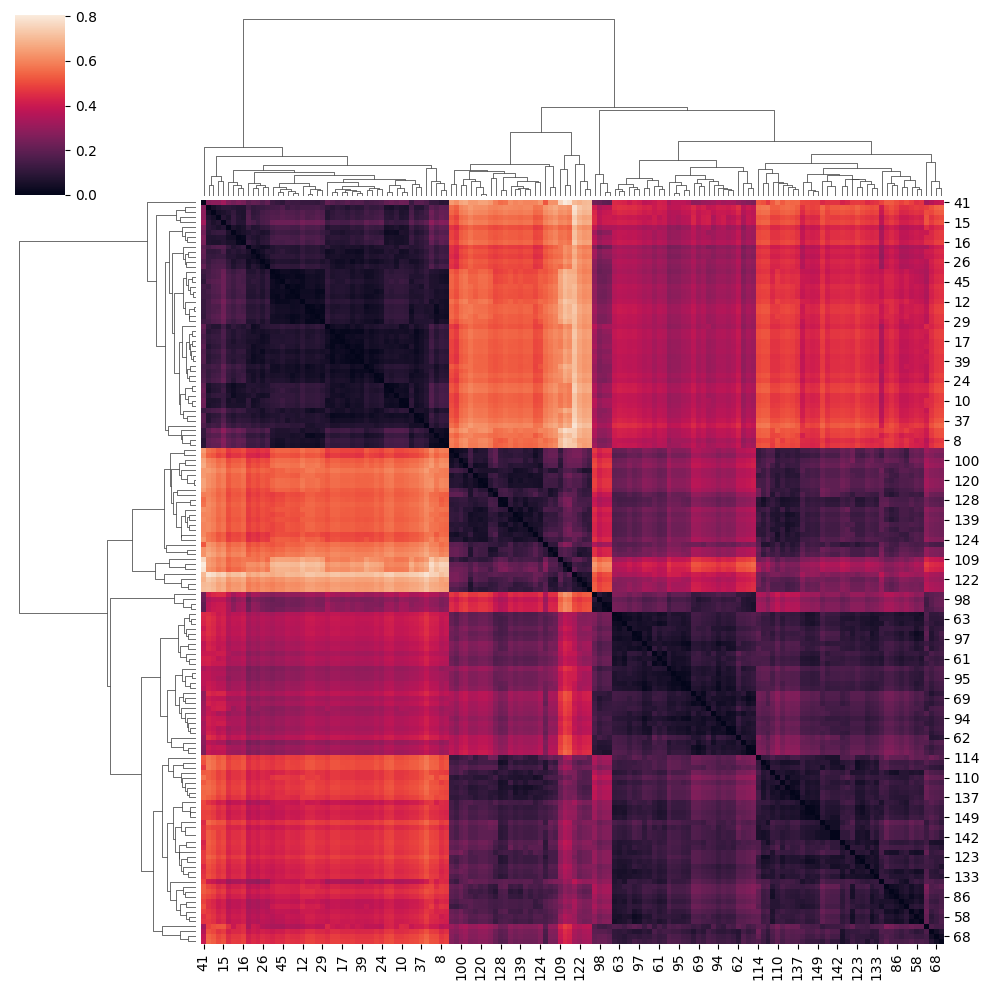

In [84]:
from sklearn.datasets import load_iris
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc
iris = load_iris()
x,y = iris.data,iris.target
DF = pd.DataFrame(x,index=["iris_%d" % (i) for i in range(x.shape[0])],columns=iris.feature_names)

linkage = hc.linkage(gower.gower_matrix(DF),method='average')
sns.clustermap(gower.gower_matrix(DF),row_linkage=linkage,col_linkage=linkage)

#dist_matrix = gower.gower_dist(DF)
#g = sns.clustermap(dist_matrix, metric='precomputed', row_colors=row_colors, figsize=(20,20))


In [35]:
print('\t\t\t# patients\t# variables')
d = data.query("mut==True")
print('\nmut\t\t\t',len(d),'\t\t',len(cols_mut)) 
d = data.query("cna==True")
print('cna\t\t\t',len(d),'\t\t',len(cols_cna)) 
d = data.query("rna==True")
print('rna\t\t\t',len(d),'\t\t',len(cols_rna)) 
d = data.query("meth==True")
print('meth\t\t\t',len(d),'\t\t',len(cols_meth)) 

d = data.query("mut==True and cna==True and rna==True and meth==True")
print('\nmut, cna, rna, meth\t',len(d),'\t\t',len(cols_mut+cols_cna+cols_rna+cols_meth))

d = data.query("mut==True and cna==True and rna==True")
print('\nmut, cna, rna\t\t',len(d),'\t\t',len(cols_mut+cols_cna+cols_rna)) 
d = data.query("mut==True and cna==True and meth==True")
print('mut, cna, meth\t\t',len(d),'\t\t',len(cols_mut+cols_cna+cols_meth))
d = data.query("mut==True and rna==True and meth==True")
print('mut, rna, meth\t\t',len(d),'\t\t',len(cols_mut+cols_rna+cols_meth))
d = data.query("cna==True and rna==True and meth==True")
print('cna, rna, meth\t\t',len(d),'\t\t',len(cols_cna+cols_rna+cols_meth))

d = data.query("mut==True and cna==True")
print('\nmut, cna\t\t',len(d),'\t\t',len(cols_mut+cols_cna)) 
d = data.query("mut==True and rna==True")
print('mut, rna\t\t',len(d),'\t\t',len(cols_mut+cols_rna)) 
d = data.query("cna==True and rna==True")
print('cna, rna\t\t',len(d),'\t\t',len(cols_cna+cols_rna)) 

			# patients	# variables

mut			 2135 		 28
cna			 2173 		 126
rna			 1980 		 62
meth			 1418 		 54

mut, cna, rna, meth	 1253 		 270

mut, cna, rna		 1691 		 216
mut, cna, meth		 1254 		 208
mut, rna, meth		 1253 		 144
cna, rna, meth		 1417 		 242

mut, cna		 1854 		 154
mut, rna		 1691 		 90
cna, rna		 1980 		 188
